# Using SteamDB price history data to predict when a game will go on sale

Import necessary packages

In [51]:
import pandas as pd
import numpy as np
import sklearn as sk

Get sample data from SteamDB

Columns: Date, Final Price, Historical Low Price

In [52]:
data = pd.read_csv('chart2.csv')
data

,DateTime,Final price,Historical low
0,2012-11-22 14:23:33,9.99,9.99
1,2012-12-03 18:26:03,4.99,4.99
2,2012-12-20 21:26:37,9.99,4.99
3,2012-12-23 19:10:22,4.99,4.99
4,2012-12-27 20:22:14,9.99,4.99
...,...,...,...
146,2024-05-30 17:01:18,9.99,0.99
147,2024-06-27 17:49:39,0.99,0.99
148,2024-07-11 17:26:20,9.99,0.99
149,2024-09-04 04:36:50,9.99,0.99


Convert given DateTime format into separate year, month, and day columns for easier training

In [53]:
data['DateTime'] = pd.to_datetime(data['DateTime'])

data['year'] = data['DateTime'].dt.year
data['month'] = data['DateTime'].dt.month
data['day'] = data['DateTime'].dt.day

data.head()


,DateTime,Final price,Historical low,year,month,day
0,2012-11-22 14:23:33,9.99,9.99,2012,11,22
1,2012-12-03 18:26:03,4.99,4.99,2012,12,3
2,2012-12-20 21:26:37,9.99,4.99,2012,12,20
3,2012-12-23 19:10:22,4.99,4.99,2012,12,23
4,2012-12-27 20:22:14,9.99,4.99,2012,12,27


Create a column that says if the final price is equal to the historical low (best deal price)

In [54]:
data['price_equal'] = np.where(data['Final price'] == data['Historical low'], 1, 0)

data.head()

,DateTime,Final price,Historical low,year,month,day,price_equal
0,2012-11-22 14:23:33,9.99,9.99,2012,11,22,1
1,2012-12-03 18:26:03,4.99,4.99,2012,12,3,1
2,2012-12-20 21:26:37,9.99,4.99,2012,12,20,0
3,2012-12-23 19:10:22,4.99,4.99,2012,12,23,1
4,2012-12-27 20:22:14,9.99,4.99,2012,12,27,0


In [55]:
from datetime import timedelta

def add_missing_dates(df):
    new_rows = []
    for i in range(len(df) - 1):
        current_row = df.iloc[i]
        next_row = df.iloc[i + 1]
        current_date = current_row['DateTime']
        next_date = next_row['DateTime']
        while current_date + timedelta(days=1) < next_date:
            current_date += timedelta(days=1)
            new_row = current_row.copy()
            new_row['DateTime'] = current_date
            new_row['year'] = current_date.year
            new_row['month'] = current_date.month
            new_row['day'] = current_date.day
            new_rows.append(new_row)
    return pd.concat([df, pd.DataFrame(new_rows)]).sort_values(by='DateTime').reset_index(drop=True)

# Add missing dates
expanded_data = add_missing_dates(data)

print(expanded_data)

data = expanded_data.dropna()

                DateTime  Final price  Historical low  year  month  day  \
0    2012-11-22 14:23:33         9.99            9.99  2012     11   22   
1    2012-11-23 14:23:33         9.99            9.99  2012     11   23   
2    2012-11-24 14:23:33         9.99            9.99  2012     11   24   
3    2012-11-25 14:23:33         9.99            9.99  2012     11   25   
4    2012-11-26 14:23:33         9.99            9.99  2012     11   26   
...                  ...          ...             ...   ...    ...  ...   
4377 2024-09-01 17:26:20         9.99            0.99  2024      9    1   
4378 2024-09-02 17:26:20         9.99            0.99  2024      9    2   
4379 2024-09-03 17:26:20         9.99            0.99  2024      9    3   
4380 2024-09-04 04:36:50          NaN            0.99  2024      9    4   
4381 2024-09-04 04:36:50         9.99            0.99  2024      9    4   

      price_equal  
0               1  
1               1  
2               1  
3               1  

Create scatterplot to show expanded data

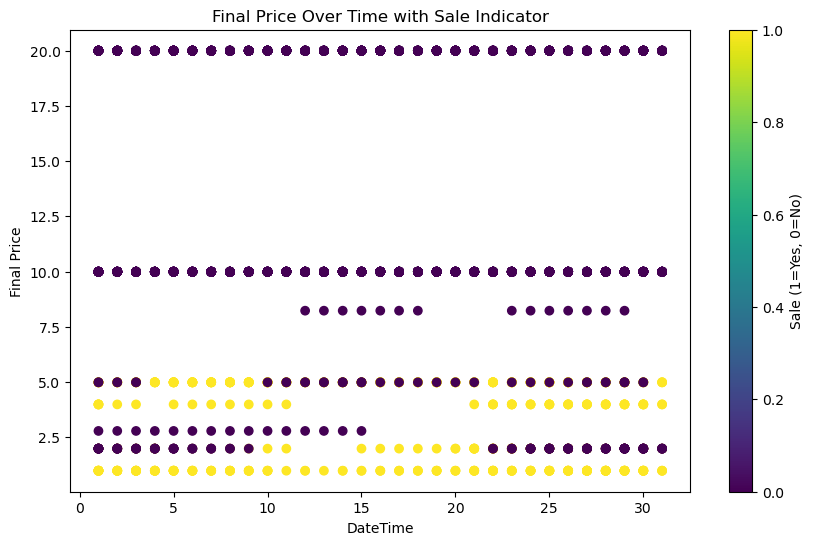

In [56]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
scatter = plt.scatter(data['day'], data['Final price'], c=data['price_equal'], cmap='viridis', label='Sale')

cbar = plt.colorbar(scatter)
cbar.set_label('Sale (1=Yes, 0=No)')

plt.xlabel('DateTime')
plt.ylabel('Final Price')
plt.title('Final Price Over Time with Sale Indicator')

plt.show()

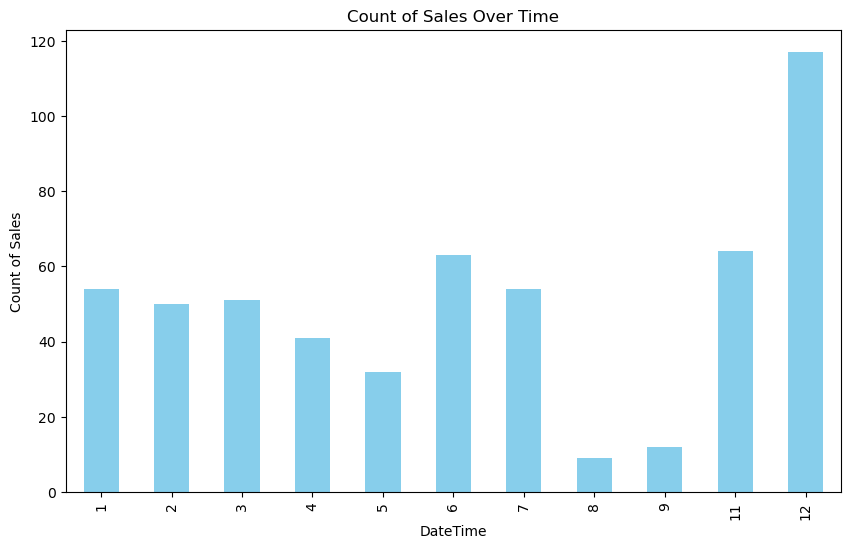

In [57]:
import matplotlib.pyplot as plt

sale_counts = data[data['price_equal'] == 1].groupby('month').size()

plt.figure(figsize=(10, 6))
sale_counts.plot(kind='bar', color='skyblue')

plt.xlabel('DateTime')
plt.ylabel('Count of Sales')
plt.title('Count of Sales Over Time')

plt.show()

Create feature and label sets

In [58]:
cleaned_data = data.drop("DateTime", axis=1)

features = cleaned_data.drop(['Final price', 'Historical low', 'price_equal', 'year'], axis=1)

label = cleaned_data['price_equal']

features.head()


,month,day
0,11,22
1,11,23
2,11,24
3,11,25
4,11,26


#### Grid-search Decision Tree Classifier (optimized params)

Testing grid search cross validation tree to see if accuracy can be improved by adjusting parameters

In [59]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

decision_tree = DecisionTreeClassifier(criterion='gini')
param_grid = {'max_depth': [5,10,15], 'min_samples_leaf': [5,10,15], 'max_features': [5,10,15]}
grid_search_DT = GridSearchCV(decision_tree, param_grid, scoring='accuracy')
nested_cv = cross_val_score(grid_search_DT, features, label)
prediction = cross_val_predict(grid_search_DT, features, label)
print(confusion_matrix(label, prediction))

accuracy = nested_cv.sum() / len(nested_cv)

print('Accuracy of Decision Tree: ', accuracy)

[[3748   86]
 [ 471   76]]
Accuracy of Decision Tree:  0.8728708809088683


In [60]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.2, random_state=42)

# Initialize the Decision Tree Classifier
decision_tree = DecisionTreeClassifier()

# Define the parameter grid
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5, 10],
    'max_features': [None, 'auto', 'sqrt', 'log2']
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=decision_tree, param_grid=param_grid, scoring='accuracy', cv=5)

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print(f'Best parameters: {best_params}')

# Evaluate the model with the best parameters
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Print the confusion matrix
print(confusion_matrix(y_test, y_pred))

Best parameters: {'criterion': 'entropy', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 5}
Accuracy: 0.8722919042189282
[[745  19]
 [ 93  20]]


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
480 fits failed out of a total of 1920.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
480 fits failed with the following error:
Traceback (most recent call last):
  File "c:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py", line 637, in _validate_params
    validate_parameter_constraints(
  File "c:\ProgramData\anaconda3\Lib\site-packa

Create optimized decision tree classifier with best params

In [61]:
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB

X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.2, random_state=42)

optimal_clf = DecisionTreeClassifier(**best_params)

optimal_clf.fit(X_train, y_train)

y_pred = optimal_clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

print(accuracy)

0.8779931584948689


Predict whether game will be on sale given a single date

0 - not on sale (final price does not match lowest historical price)

1 - on sale (final price matches lowest historical price)

In [62]:
new_data = pd.DataFrame({'month': [9], 'day': [19]})

pred_outcome = optimal_clf.predict(new_data)

print(pred_outcome)

[0]


Predict whether there will be a sale for a range of future dates

In [63]:
for month in range(9,13):
    
    for day in range(1, 31):
        new_data = pd.DataFrame({'month': [month], 'day': [day]})

        pred_outcome = optimal_clf.predict(new_data)

        if (pred_outcome == [1]):
            print(month, ' ', day ,' ' , pred_outcome)

11   25   [1]
11   26   [1]
11   27   [1]
11   28   [1]
12   22   [1]
12   23   [1]
12   24   [1]
12   25   [1]
12   26   [1]
12   27   [1]
12   28   [1]
12   29   [1]
12   30   [1]


#### Basic Decision Tree Classifier (without optimized params)

Creating basic Decision Tree Classifier for the features and label datasets

In [64]:
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB

X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.2, random_state=42)

clf = DecisionTreeClassifier()

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

print(accuracy)

0.8734321550741163


Predict whether game will be on sale given a single date

0 - not on sale (final price does not match lowest historical price)

1 - on sale (final price matches lowest historical price)

In [65]:
new_data = pd.DataFrame({'month': [9], 'day': [19]})

pred_outcome = clf.predict(new_data)

print(pred_outcome)

[0]


Checks each date in a given month to see if game will be on sale

In [66]:
for x in range(1,30):
    new_data = pd.DataFrame({ 'month': [9], 'day': [x]})

    pred_outcome = clf.predict(new_data)

    print(x ,' ' , pred_outcome)

1   [0]
2   [0]
3   [0]
4   [0]
5   [0]
6   [0]
7   [0]
8   [0]
9   [0]
10   [0]
11   [0]
12   [0]
13   [0]
14   [0]
15   [0]
16   [0]
17   [0]
18   [0]
19   [0]
20   [0]
21   [0]
22   [0]
23   [0]
24   [0]
25   [0]
26   [0]
27   [0]
28   [0]
29   [0]


Predict whether there will be a sale for a range of future dates

In [67]:
for month in range(9,13):
    
    for day in range(1, 31):
        new_data = pd.DataFrame({'month': [month], 'day': [day]})

        pred_outcome = clf.predict(new_data)

        #if (pred_outcome == [1]):
        print(month, ' ', day ,' ' , pred_outcome)

9   1   [0]
9   2   [0]
9   3   [0]
9   4   [0]
9   5   [0]
9   6   [0]
9   7   [0]
9   8   [0]
9   9   [0]
9   10   [0]
9   11   [0]
9   12   [0]
9   13   [0]
9   14   [0]
9   15   [0]
9   16   [0]
9   17   [0]
9   18   [0]
9   19   [0]
9   20   [0]
9   21   [0]
9   22   [0]
9   23   [0]
9   24   [0]
9   25   [0]
9   26   [0]
9   27   [0]
9   28   [0]
9   29   [0]
9   30   [0]
10   1   [0]
10   2   [0]
10   3   [0]
10   4   [0]
10   5   [0]
10   6   [0]
10   7   [0]
10   8   [0]
10   9   [0]
10   10   [0]
10   11   [0]
10   12   [0]
10   13   [0]
10   14   [0]
10   15   [0]
10   16   [0]
10   17   [0]
10   18   [0]
10   19   [0]
10   20   [0]
10   21   [0]
10   22   [0]
10   23   [0]
10   24   [0]
10   25   [0]
10   26   [0]
10   27   [0]
10   28   [0]
10   29   [0]
10   30   [0]
11   1   [0]
11   2   [0]
11   3   [0]
11   4   [0]
11   5   [0]
11   6   [0]
11   7   [0]
11   8   [0]
11   9   [0]
11   10   [0]
11   11   [0]
11   12   [0]
11   13   [0]
11   14   [0]
11   15   [0]
11   16

#### Basic Neural Net model

Test using a neural network model to see if accuracy improves and how it changes what predicted dates sales occur on

In [68]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score



# Features and labels
X = features
y = label

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Build the neural network model
mlp = MLPClassifier(hidden_layer_sizes=(10, 5), max_iter=1000, random_state=42)

# Train the model
mlp.fit(X_train, y_train)

# Make predictions
y_pred = mlp.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.8768529076396807


Predict whether there will be a sale on one future date

In [69]:
# Predict the outcome for a new datapoint
new_data = pd.DataFrame({'month': [12], 'day': [29]})
new_data = scaler.transform(new_data)
predicted_outcome = mlp.predict(new_data)
print(f'Predicted outcome for new data: {predicted_outcome[0]}')


Predicted outcome for new data: 1


Predict whether there will be a sale for a range of future dates

In [70]:
for month in range(9,13):
    
    for day in range(1, 31):
        new_data = pd.DataFrame({'month': [month], 'day': [day]})
        new_data = scaler.transform(new_data)
        predicted_outcome = mlp.predict(new_data)
        if(predicted_outcome[0] == 1):
            print(month, day)
            print(f'Predicted outcome for {predicted_outcome[0]}')

12 23
Predicted outcome for 1
12 24
Predicted outcome for 1
12 25
Predicted outcome for 1
12 26
Predicted outcome for 1
12 27
Predicted outcome for 1
12 28
Predicted outcome for 1
12 29
Predicted outcome for 1
12 30
Predicted outcome for 1
